# Проект: Предсказание стоимости жилья

## Цели работы:

- Обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году для предсказания медианной стоимости дома в жилом массиве.
- Оценить качество модели по метрикам RMSE, MAE и R2.
- При работе использховать фреймворк Apache Spark.

## Краткий план работы

| **№ п/п** | **Задача** | **Срок выполнения** |
| :---: | :--- | :---: |
|1.|Инициализировать локальную Spark-сессию. Загрузить данные. Ознакомиться с ними.|16.08.2024|
|2.|Выполните предобработку данных. Обработать пропуски.|17.08.2024|
|3.|Провести подготовку данных. Отобрать и сконструировать признаки. Оценить корелляцию признаков.|18.09.2024|
|4.|Построить две модели линейной регрессии на разных наборах данных: используя все данные из файла и используя только числовые переменные, исключив категориальные.|19.09.2024|
|5.|Сравнить результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2.|22.09.2024|
|6.|Обучить RandomForestRegressor с перебором гиперпараметров и сравнить результаты с двумя предыдущими моделями|22.09.2024|
|7.|Сформулировать выводы.|23.09.2024|

## Исходные данные

Набор данных:
- __housing.csv__ - информация о 20640 жилых массивах в Калифорнии за 1990 год.

| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__longitude__|Широта|
|2.|__latitude__|Долгота|
|3.|__housing_median_age__|Медианный возраст жителей жилого массива|
|4.|__total_rooms__|Общее количество комнат в домах жилого массива|
|5.|__total_bedrooms__|Общее количество спален в домах жилого массива|
|6.|__population__|Количество человек, которые проживают в жилом массиве|
|7.|__households__|Количество домовладений в жилом массиве|
|8.|__median_income__|Медианный доход жителей жилого массива|
|8.|__median_house_value__|__Целевая переменная__. Медианная стоимость дома в жилом массиве|
|9.|__ocean_proximity__|Близость к океану|

# Ход работы

## Импорт необходимых библиотек. Инициализация Spark-сесии. Загрузка данных. Ознакомление с данными.

In [1]:
# импортируем модуль для работы с операционной системой
import os

# импортируем модуль для загрузки файлов из сети
import requests

# импортируем библиотеку numpy для работы с массивами и числовыми данными
import numpy as np

# импортируем библиотеку pandas для работы с табличными данными
import pandas as pd

# импортируем seaborn для создания статистических графиков
import seaborn as sns

# импортируем matplotlib для построения графиков
import matplotlib.pyplot as plt

# импортируем SparkSession для создания сессии Spark
from pyspark.sql import SparkSession

# импортируем модуль для работы с функциями Spark, включая агрегатные и математические функции
import pyspark.sql.functions as F

# импортируем класс Pipeline для создания конвейера трансформаций и модели
from pyspark.ml import Pipeline

# импортируем OneHotEncoder для кодирования категориальных переменных в формат "one-hot"
from pyspark.ml.feature import OneHotEncoder

# импортируем StringIndexer для кодирования строковых категорий в числовой формат
from pyspark.ml.feature import StringIndexer

# импортируем VectorAssembler для объединения нескольких столбцов в один векторный столбец
from pyspark.ml.feature import VectorAssembler

# импортируем StandardScaler для стандартизации признаков (нормализации)
from pyspark.ml.feature import StandardScaler

# импортируем RandomForestRegressor и LinearRegression для создания и обучения моделей регрессии
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

# импортируем RegressionEvaluator для оценки модели регрессии (например, по RMSE, MAE, R²)
from pyspark.ml.evaluation import RegressionEvaluator

# импортируем ParamGridBuilder для пеербора гиперпараметров
from pyspark.ml.tuning import ParamGridBuilder

# импортируем инструмент для кросс-валидации
from pyspark.ml.tuning import CrossValidator

# импортируем Correlation для вычисления корреляции между признаками
from pyspark.ml.stat import Correlation

# инициализируем констнату для разделения выборки на train и test
RANDOM_SEED = 42

In [2]:
# настраиваем окружение для локальной работы Spark
os.environ['SPARK_HOME'] = '/opt/anaconda3/envs/spark_project/lib/python3.9/site-packages/pyspark'
os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/envs/spark_project/bin/python'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['SPARK_HOME'], 'bin')

In [3]:
# инициализируем Spark-сессию
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Housing Value Prediction Spark Project") \
    .getOrCreate()

24/09/27 18:59:21 WARN Utils: Your hostname, Sergeys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.8.101 instead (on interface en0)
24/09/27 18:59:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/27 18:59:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# убираем лишнее логгирование
spark.sparkContext.setLogLevel("ERROR")

In [5]:
# определение функции для инициализаци датасета
# функция принимает в качестве аргументов локальный путь, сетевой путь и разделитель для датасета
def fetch_data(local_path, url, sep=','):
    # проверяет существует ли локальный файл csv
    # если нет, загружает файл из сети с выводом соответствующего уведомления
    if not os.path.exists(local_path):
        print('Local file', local_path, 'does not exist.\nDownloading from', url)
        # сохраняем файл в соответствующей директории
        response = requests.get(url)
        with open(local_path, 'wb') as file:
            file.write(response.content)
    # функция возвращает объект <DataFrame> (Spark)
    return spark.read.load(
        local_path, format="csv", sep=sep, inferSchema=True, header="true"
    )

In [6]:
# инициализация локального и удаленного путей к файлу с данными
local_path = '/Users/sergey/Documents/Practicum/DS/3 module/housing.csv'
url = 'https://code.s3.yandex.net/datasets/housing.csv'

In [7]:
# инициализируем датасет
df_housing = fetch_data(local_path=local_path, url=url)

Local file /Users/sergey/Documents/Practicum/DS/3 module/housing.csv does not exist.


Выводим общую информацию о данных.

In [8]:
df_housing.printSchema() 

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [9]:
df_housing.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



Смотрим описательные статистики.

In [10]:
df_housing.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


### Промежуточные выводы по ознакомлению с данными

- Данные соответствуют описанию.
- Нейминг столбцов соостветствует принятым соглашениям.
- В данных есть пропуски. Для определения стратегии работы с пропусками необходимо провести дополнительный анализ.

Добавляем несколько новых признаков.

In [11]:
df_housing = df_housing\
    .withColumn('rooms_per_household', df_housing['total_rooms'] / df_housing['households'])\
    .withColumn('population_in_household', df_housing['population'] / df_housing['households'])\
    .withColumn('bedroom_rate', df_housing['total_bedrooms'] / df_housing['total_rooms'])
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_rate: double (nullable = true)



## Предобработка данных

Смотрим на наличие пропусков.

In [12]:
columns = df_housing.columns
for column in columns:
    null_count = df_housing.filter(
        F.col(column).isNull() | F.isnan(F.col(column))
    ).count()
    print(column, null_count)

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
rooms_per_household 0
population_in_household 0
bedroom_rate 207


Пропуски в колонке `total_bedrooms` можно заполнить исходя и отношения количествв спален к общему количества комнат. Посмотрим на корреляцию этих признаков.

In [13]:
rooms = df_housing.select(
    ['total_rooms', 'total_bedrooms']
).toPandas()

In [14]:
rooms.corr()

,total_rooms,total_bedrooms
total_rooms,1.00000,0.93038
total_bedrooms,0.93038,1.00000


Коэффициент корреляции `0,93`. Пропуски в колонке `total_bedrooms` целесообразно заполнить произведением значения в колонке `total_rooms` и среднего значения `bedroom_rate`.

In [15]:
# рассчитываем среднее значение bedroom_rate
average_bedroom_rate = df_housing.select(
    F.avg(F.col('bedroom_rate'))
).first()['avg(bedroom_rate)']

In [16]:
# заполняем пропуски в total_bedrooms
df_housing = df_housing.withColumn(
    'total_bedrooms',
    F.when(
        F.col('total_bedrooms').isNull(),
        F.col('total_rooms') * average_bedroom_rate  # используем среднее значение
    ).otherwise(F.col('total_bedrooms'))
)

Пропуски в колонке `bedroom_rate` заполним средним.

In [17]:
fill_values = {'bedroom_rate': average_bedroom_rate}
df_housing = df_housing.fillna(fill_values)

In [18]:
# проверяем результат заполнения пропусков
columns = df_housing.columns
for column in columns:
    null_count = df_housing.filter(
        F.col(column).isNull() | F.isnan(F.col(column))
    ).count()
    print(column, null_count)

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
rooms_per_household 0
population_in_household 0
bedroom_rate 0


### Промежуточные выводы по предобработке данных

- Пропуски в колонке `total_bedrooms` заполнены исходя из отношения числа спален к общему числу комнат.
- Пропуски в колонке `bedroom_rate` заполнены средним.

## Исследовательский анализ данных

В рамках исследовательского анализа посмотрим на корреляцию признаков.

In [19]:
# определяем список признаков для корреляционного анализа
corr_features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    #'ocean_proximity', исключаем категориальный признак
    'rooms_per_household',
    'population_in_household',
    'bedroom_rate'
]

Собираем признаки в один вектор с помощью `VectorAssembler`.

In [20]:
corr_assembler = VectorAssembler(
    inputCols=corr_features,
    outputCol='corr_features'
)

In [21]:
corr_vector = corr_assembler.transform(df_housing).select('corr_features')

In [22]:
# вычисление матрицы корреляции
correlation_matrix = Correlation.corr(corr_vector, 'corr_features').head()['pearson(corr_features)']

Определим функцию для вывода матрицы корреляции.

In [23]:
def plot_corr(data, title=''):
    
    # строим heatmap с помощью библиотеки seaborn
    plt.figure(figsize=(7, 7))
    ax = sns.heatmap(
        data, 
        annot=True, 
        #mask=mask, 
        vmin=-1, 
        vmax=1, 
        cmap='viridis', 
        cbar=False, 
        square=True
    )
    ax.set_title(title)
    plt.show()

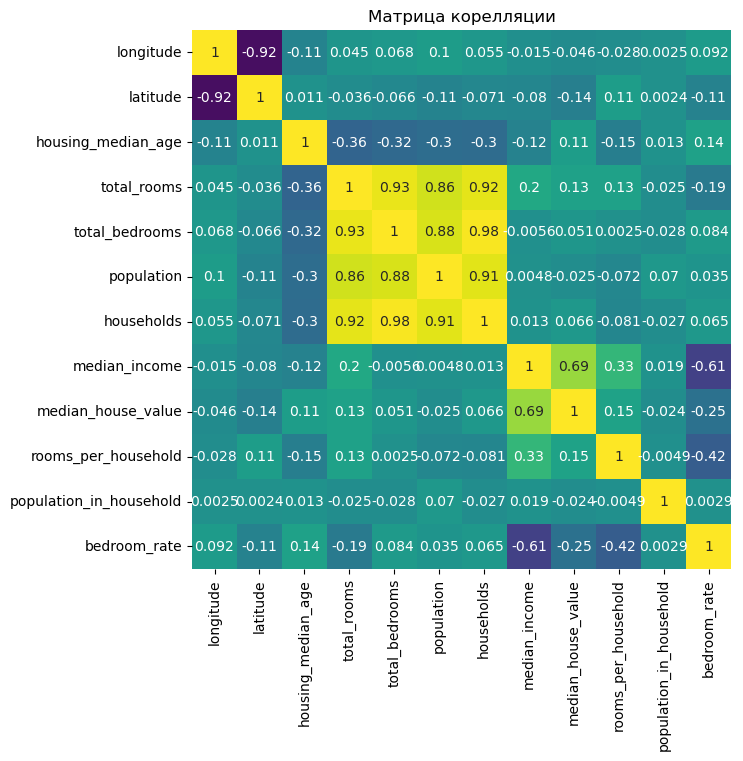

In [24]:
# отрисовываем матрицу
plot_corr(
    data=pd.DataFrame(correlation_matrix.toArray(), columns=corr_features, index=corr_features), 
    title='Матрица корелляции'
)

### Промежуточные выводы по исследовательскому анализу данных

- Наиболее сильную линейную взаимосвязь с таргетом имеет признак `median_income`.
- Признаки `total_rooms`, `total_bedrooms`, `population` и `households` мультиколлинеарны.
- Искусственный признак `bedroom_rate` имеет более сильную взаимосвязь с таргетом, чем признаки `total_rooms` и `total_bedrooms` по отдельности.

## Подготовка данных

Определяем списки признаков.

In [25]:
# числовые признаки
num_features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    #'median_house_value', исключаем таргет
    'rooms_per_household',
    'population_in_household',
    'bedroom_rate'
]

cat_features = [
    'ocean_proximity'
]

output_idx_cat_features = [col +'_idx' for col in cat_features]
output_ohe_cat_features = [col +'_ohe' for col in cat_features]

all_features = [
    'categorical_features_encoded',
    'numerical_features_scaled'
]

Кодируем категориальный признак.

In [26]:
# преобразование категориальной переменной в числовую
# StringIndexer преобразует строковые значения в числовые индексы
indexer = StringIndexer(
    inputCols=cat_features,
    outputCols=output_idx_cat_features
)

In [27]:
# OneHotEncoder преобразует числовые индексы в one-hot представление
encoder = OneHotEncoder(
    inputCols=output_idx_cat_features,
    outputCols=output_ohe_cat_features
)

In [28]:
categorical_assembler = VectorAssembler(
    inputCols=[col+'_ohe' for col in cat_features],
    outputCol='categorical_features_encoded'
)

Масштабируем числовые признаки.

In [29]:
numerical_assembler = VectorAssembler(
    inputCols=num_features,
    outputCol='num_features_vec'
)

In [30]:
standard_scaler = StandardScaler(
    inputCol='num_features_vec',
    outputCol='numerical_features_scaled',
    withMean=True
)

Собираем все признаки в один вектор.

In [31]:
final_assembler = VectorAssembler(
    inputCols=all_features,
    outputCol='features'
)

Делим выборку на train и test.

In [32]:
train_data, test_data = df_housing.randomSplit([.75,.25], seed=RANDOM_SEED)

Проверяем размеры выборок.

In [33]:
print(train_data.count(), test_data.count()) 

15500 5140


Данные готовы для обучения модели.

## Обучение моделей

### Обучение модели на всех данных

In [34]:
# создание модели линейной регрессии
lr_with_cat = LinearRegression(featuresCol='features', labelCol='median_house_value')

In [35]:
# создание Pipeline
pipeline = Pipeline(
    stages=[
        indexer,
        encoder,
        categorical_assembler,
        numerical_assembler,
        standard_scaler,
        final_assembler,
        lr_with_cat
    ]
)

In [36]:
# обучение модели
model_with_cat = pipeline.fit(train_data)

### Обучение модели на данных без категориального признака

In [37]:
all_features = [
    #'categorical_features_encoded', исключаем кат. признак
    'numerical_features_scaled'
]

In [38]:
final_assembler = VectorAssembler(
    inputCols=all_features,
    outputCol='features'
)

In [39]:
lr_without_cat = LinearRegression(featuresCol='features', labelCol='median_house_value')

In [40]:
# создание Pipeline
pipeline = Pipeline(
    stages=[
        #indexer, исключаем обработку кат. признака
        #encoder, исключаем обработку кат. признака
        #categorical_assembler, исключаем обработку кат. признака
        numerical_assembler,
        standard_scaler,
        final_assembler,
        lr_without_cat
    ]
)

In [41]:
# обучение модели
model_without_cat = pipeline.fit(train_data)

### Обучение модели RandomForestRegressor

Собираем данные в один вектор.

In [42]:
all_features = [
    'categorical_features_encoded',
    'numerical_features_scaled'
]

In [43]:
final_assembler = VectorAssembler(
    inputCols=all_features,
    outputCol='features'
)

Инициализируем модель `RandomForestRegressor`.

In [44]:
rf = RandomForestRegressor(featuresCol='features', labelCol='median_house_value')

In [45]:
# создание Pipeline
pipeline = Pipeline(
    stages=[
        indexer,
        encoder,
        categorical_assembler,
        numerical_assembler,
        standard_scaler,
        final_assembler,
        rf # в этот пайплайн передаем RandomForestRegressor
    ]
)

Инициализируем `ParamGridBuilder` для создания сетки гиперпараметров.

In [46]:
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

Инициализируем `RegressionEvaluator`.

In [47]:
evaluator_cv = RegressionEvaluator(
    labelCol='median_house_value',
    predictionCol='prediction',
    metricName='rmse'
)

Инициализируем инструмент для перебора гиперпараметров на кросс-валидации.

In [48]:
cross_val = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_cv,
    numFolds=3
)

Обучаем модель.

In [49]:
cv_model = cross_val.fit(train_data)

# Анализ результатов

Определим функцию для вывода метрик __RMSE__, __MAE__ и __R2__.

In [50]:
def get_evaluation(model, test_data, metric_name):
    predictions = model.transform(test_data)
    evaluator = RegressionEvaluator(
        labelCol='median_house_value',
        predictionCol='prediction',
        metricName=metric_name
    )
    return evaluator.evaluate(predictions)

Определяем список метрик.

In [51]:
metrics = ['rmse', 'mae', 'r2']

Оцениваем качество модели, обученной на всех признаках.

In [52]:
for metric_name in metrics:
    print(f'{metric_name.upper()}: {get_evaluation(model_with_cat, test_data, metric_name)}')

RMSE: 69508.5717203063
MAE: 49590.63398938042
R2: 0.6440338467872601


Оцениваем качество модели, обученной только на числовых признаках.

In [53]:
for metric_name in metrics:
    print(f'{metric_name.upper()}: {get_evaluation(model_without_cat, test_data, metric_name)}')

RMSE: 70346.88029163038
MAE: 50308.60097362224
R2: 0.6353958053311011


Оцениваем качество модели `RandomForestRegressor`, обученной на всех признаках.

In [54]:
for metric_name in metrics:
    print(f'{metric_name.upper()}: {get_evaluation(cv_model, test_data, metric_name)}')

RMSE: 50242.78045654983
MAE: 34122.48261012284
R2: 0.8140144056157204


In [55]:
# получаем лучшую модель
best_model = cv_model.bestModel.stages[-1]

In [56]:
best_model

RandomForestRegressionModel: uid=RandomForestRegressor_49a8b0ae8227, numTrees=30, numFeatures=15

In [57]:
# получаем массив со сначениями важности признаков
importances = best_model.featureImportances

In [58]:
# получение количества уникальных значений в категориальном признаке
unique_category_count = df_housing.select('ocean_proximity').distinct().count()

In [59]:
# формируем список всех признаков после кодирования
# количество закодированных категорий = количество уникальных категорий минус 1 (dropLast)
feature_names = [f'ocean_proximity_{i}' for i in range(unique_category_count) if i != 0]

In [60]:
# добавляем остальные признаки (в данном случае числовые признаки)
feature_names = feature_names + num_features

In [61]:
# инициализируем датасет pandas
importances_df = pd.DataFrame(
    data=importances.values,
    index=feature_names,
    columns=['Importance']
)

In [62]:
# сортируем значения по убыванию
importances_df = importances_df.sort_values(by='Importance', ascending=False)

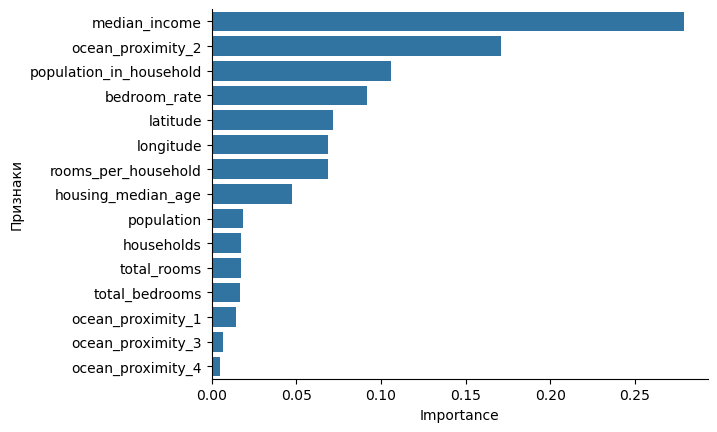

In [63]:
# отрисовываем важность признаков на диаграмме
ax = sns.barplot(
    data=importances_df,
    y=importances_df.index,
    x='Importance',
    orient='h'
)
ax.set_ylabel('Признаки')
sns.despine()
plt.show()

# Выводы по результатам работы

__Цель проекта__ - обучить 2 модели линейной регрессии на данных о жилье в Калифорнии в 1990 году для предсказания медианной стоимости дома в жилом массиве.

__Основные выполненные этапы__:
- загрузка данных и ознакомление
- заполненние пропусков
- конструирование новых признаков
- корреляционный анализ
- подготовка данных
- обучение моделей
- оценка качества

__Полученные результаты__:

1. При использовании всех признаков:

- Метрика RMSE на тестовой выборке: **69508.5717198917**
- Метрика MAE на валидационной выборке: **49590.63398859056**
- Метрика R2 на валидационной выборке: **0.6440338467915065**

2. При исключении категориального признака:

- Метрика RMSE на тестовой выборке: **70346.88029140561**
- Метрика MAE на валидационной выборке: **50308.60097259645**
- Метрика R2 на валидационной выборке: **0.6353958053334309**

3. При использовании модели `RandomForestRegressor` с перебором гиперпараметров по сетке:

- Метрика RMSE на тестовой выборке: **50234.041477042665**
- Метрика MAE на валидационной выборке: **34168.62614520738**
- Метрика R2 на валидационной выборке: **0.814079098808763**

При использовании категориального признака модель показала более высокие метрики, чем та модель, которая обучалась только на числовых признаках. Самые лучшие знаения метрик на тесте показала модель `RandomForestRegressor` с гиперпараметрами `numTrees=30`, `numFeatures=15`.
